# Airbnb price prediction

The objective of the notebook is to predict the price of Airbnb hotels in New york city.

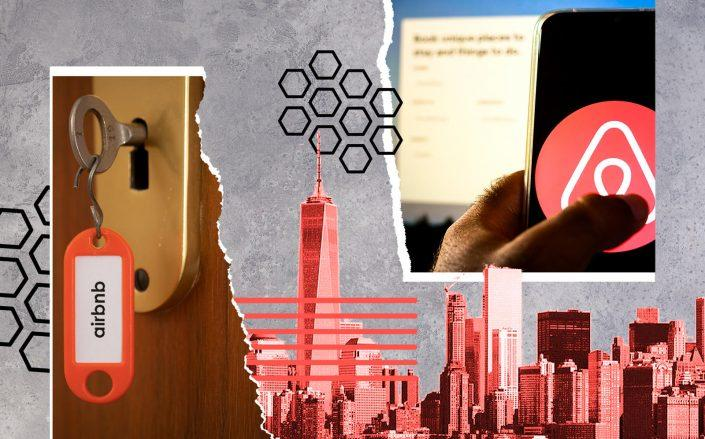

In [1]:
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


### Load all the required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


This dataset has around 49,000 observations in it with 16 columns and it is a mix between categorical and numeric values.

### Load the dataset

In [3]:
data = pd.read_csv("../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

In [4]:
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [5]:
print('Number of features: {}'.format(data.shape[1]))
print('Number of entries: {}'.format(data.shape[0]))

Number of features: 16
Number of entries: 48895


### Plotting heatmap of missing values


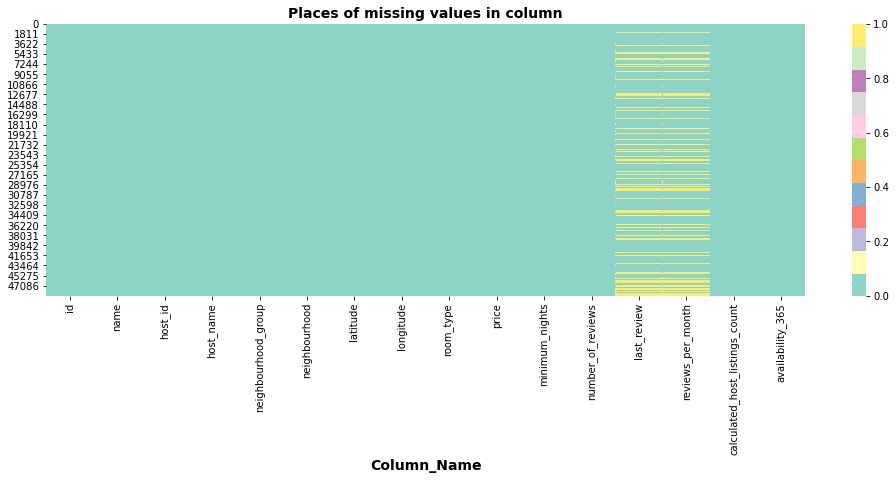

In [6]:
plt.figure(figsize=(17, 5))
sns.heatmap(data.isnull(), cbar=True, cmap='Set3')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=14)
plt.show()

### Percentage of missing values in each column

In [7]:
#make a list of the variables that contain missing values
vars_with_na=[var for var in data.columns if data[var].isnull().sum()>1]

#print the variable name and the percentage of missing values 
for var in vars_with_na:
    print(var,np.round(data[var].isnull().mean(),3),'% missing values')

name 0.0 % missing values
host_name 0.0 % missing values
last_review 0.206 % missing values
reviews_per_month 0.206 % missing values


columns "name" and "host_name" are irrelevant and insignificant to our data analysis, columns "last_review" and "review_per_month" need very simple handling. To elaborate, "last_review" is date; if there were no reviews for the listing - date simply will not exist. In our case, this column is irrelevant and insignificant therefore appending those values is not needed. For "review_per_month" column we can simply append it with 0.0 for missing values; we can see that in "number_of_review" that column will have a 0, therefore following this logic with 0 total reviews there will be 0.0 rate of reviews per month. Therefore, let's proceed with removing columns that are not important and handling of missing data.

Its clearly visible that **reviews_per_month** has maximum number of missing values.

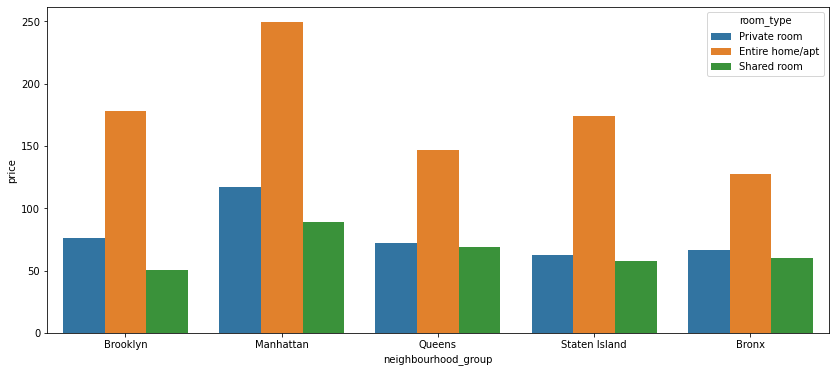

In [8]:
plt.figure(figsize=(14, 6))
sns.barplot(data.neighbourhood_group, data.price, hue=data.room_type, ci=None)

The above bar plot demonstrates:

1. Manhattan is the most expensive neighbourhood_group
2. The price of entire home/apt is more than any other room type.
3. Bronx is the cheapest.

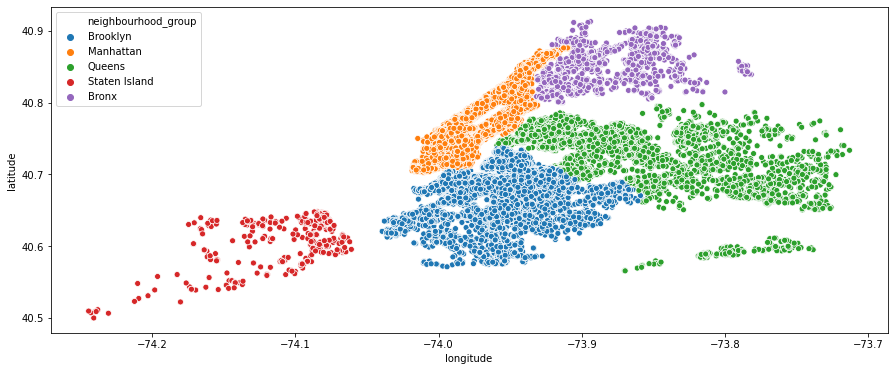

In [9]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x=data.longitude,y=data.latitude,hue=data.neighbourhood_group)

The above plot just decibes the demogrphic view of the entries in the data and also provides a clear view of the neighbourhood_groups.

### Distribution of Airbnb hotels in a Heat Map

In [10]:
m=folium.Map([40.7128,-74.0060],zoom_start=11)
HeatMap(data[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

### Nights Booked

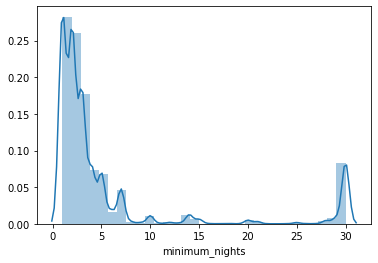

In [14]:
sns.distplot(data[(data['minimum_nights'] <= 30) & (data['minimum_nights'] > 0)]['minimum_nights'], bins=31)
plt.ioff()

### Check statics of the dataset

In [15]:
data.describe(include='all')

id            name       host_id host_name  \
count   4.889500e+04           48879  4.889500e+04     48874   
unique           NaN           47905           NaN     11452   
top              NaN  Hillside Hotel           NaN   Michael   
freq             NaN              18           NaN       417   
mean    1.901714e+07             NaN  6.762001e+07       NaN   
std     1.098311e+07             NaN  7.861097e+07       NaN   
min     2.539000e+03             NaN  2.438000e+03       NaN   
25%     9.471945e+06             NaN  7.822033e+06       NaN   
50%     1.967728e+07             NaN  3.079382e+07       NaN   
75%     2.915218e+07             NaN  1.074344e+08       NaN   
max     3.648724e+07             NaN  2.743213e+08       NaN   

       neighbourhood_group neighbourhood      latitude     longitude  \
count                48895         48895  48895.000000  48895.000000   
unique                   5           221           NaN           NaN   
top              Manhattan  Williamsburg           NaN           NaN   
freq                 21661          3920           NaN           NaN   
mean                   NaN           NaN     40.728949    -73.952170   
std                    NaN           NaN      0.054530      0.046157   
min                    NaN           NaN     40.499790    -74.244420   
25%                    NaN           NaN     40.690100    -73.983070   
50%                    NaN           NaN     40.723070    -73.955680   
75%                    NaN           NaN     40.763115    -73.936275   
max                    NaN           NaN     40.913060    -73.712990   

              room_type         price  minimum_nights  number_of_reviews  \
count             48895  48895.000000    48895.000000       48895.000000   
unique                3           NaN             NaN                NaN   
top     Entire home/apt           NaN             NaN                NaN   
freq              25409           NaN             NaN                NaN   
mean                NaN    152.720687        7.029962          23.274466   
std                 NaN    240.154170       20.510550          44.550582   
min                 NaN      0.000000        1.000000           0.000000   
25%                 NaN     69.000000        1.000000           1.000000   
50%                 NaN    106.000000        3.000000           5.000000   
75%                 NaN    175.000000        5.000000          24.000000   
max                 NaN  10000.000000     1250.000000         629.000000   

       last_review  reviews_per_month  calculated_host_listings_count  \
count        38843       38843.000000                    48895.000000   
unique        1764                NaN                             NaN   
top     2019-06-23                NaN                             NaN   
freq          1413                NaN                             NaN   
mean           NaN           1.373221                        7.143982   
std            NaN           1.680442                       32.952519   
min            NaN           0.010000                        1.000000   
25%            NaN           0.190000                        1.000000   
50%            NaN           0.720000                        1.000000   
75%            NaN           2.020000                        2.000000   
max            NaN          58.500000                      327.000000   

        availability_365  
count       48895.000000  
unique               NaN  
top                  NaN  
freq                 NaN  
mean          112.781327  
std           131.622289  
min             0.000000  
25%             0.000000  
50%            45.000000  
75%           227.000000  
max           365.000000

We see that the average price is 152. Price varies between 0 to 10K

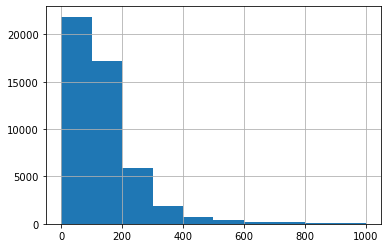

In [16]:
### Lets plot histogram for prices less than $1000
hist_price1=data["price"][data["price"]<1000].hist()

Handling outliers by removing entries having price > 1000

In [17]:
data = data[data["price"]<1000]
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

### Remove duplicates

In [18]:
##Data cleaning
#remove duplicates if any
data.duplicated().sum()
data.drop_duplicates(inplace=True)

### Drop unnecessary columns

In [19]:
#Drop unneceassry columns
data.drop(['name','id', 'host_id','last_review'], axis = 1, inplace = True)

In [20]:
#Drop NaN values
#Since reviews_per_month column has many NaN values so lets replace them with 0 instead of removing
data.fillna({'reviews_per_month' : 0}, inplace = True)
#remove Nan from rest of the column
data.isnull().sum() #to check for null values in each column
data.dropna(how = 'any', inplace = True)

### Correlation between different features

Index(['host_name', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

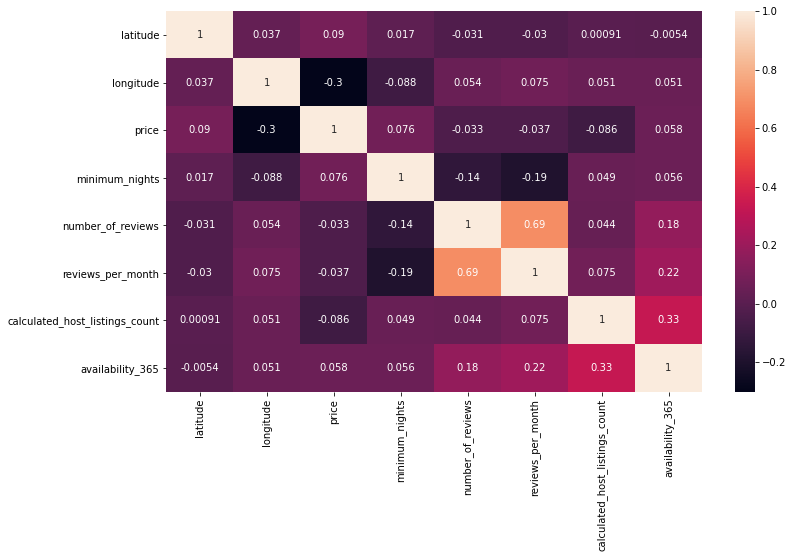

In [21]:
#Get correlation between different features
corr = data.corr(method='kendall')
plt.figure(figsize=(12,7))
sns.heatmap(corr, annot=True)
data.columns

Our features are not coorelated.

In [22]:
#Regression analysis to predict the price
#drop unneceassy columns
data.drop(['host_name','latitude','longitude','neighbourhood','number_of_reviews','reviews_per_month'], axis = 1, inplace = True)
X = data.iloc[:,[0,1,3,4,5]]
y = data['price']

### Label encoding

In [23]:
#Label encoding
X = pd.get_dummies(X, prefix=['neighbourhood_group', 'room_type'], drop_first=True)

### Split datset

In [24]:
#splitting the dataset into test and training data
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.2, random_state= 0)

In [25]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (38860, 9)
Dimensions of the training target vector: (38860,)
Dimensions of the test feature matrix: (9716, 9)
Dimensions of the test target vector: (9716,)


### Feature scaling

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model building

R2 score:  29.964369439323633
RMSE:  95.50419737600647
   Actual Values  Predicted Values
0            169        146.558847
1             40         60.025887
2            102         62.573979
3            130        205.719757
4             80         72.115130


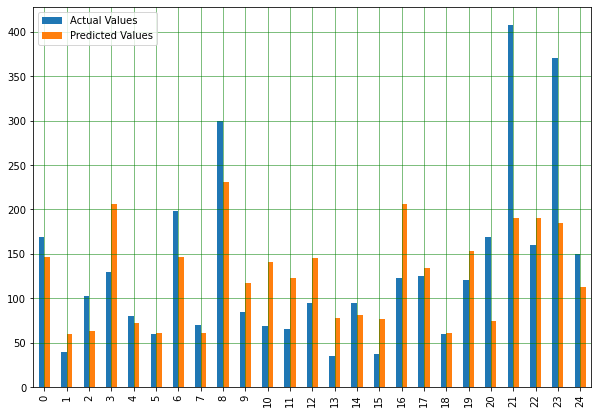

In [38]:
#Prepare a Linear Regression Model

reg=LinearRegression()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
#R2 score
from sklearn.metrics import r2_score, mean_squared_error
print("R2 score: ",r2_score(y_test,y_pred)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

#Error
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_pred.flatten()})
print(error_diff.head(5))

#Visualize the error
df1 = error_diff.head(25)
df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

R2 score:  29.963744526768853
RMSE:  95.50462345654837
   Actual Values  Predicted Values
0            169        146.523207
1             40         60.030179
2            102         62.574179
3            130        205.710218
4             80         72.116512


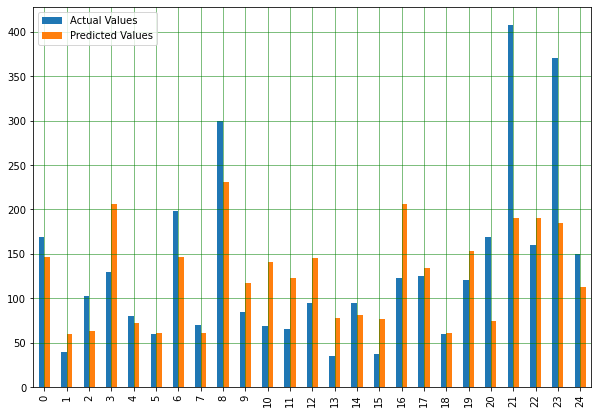

In [37]:
#Lasso regression
regL1 = Lasso(alpha=0.01)
regL1.fit(X_train, y_train) 

y_pred=regL1.predict(X_test)

from sklearn.metrics import r2_score
print("R2 score: ",r2_score(y_test,y_pred)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

#Error
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_pred.flatten()})
print(error_diff.head(5))

#Visualize the error
df1 = error_diff.head(25)
df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

R2 score:  12.67703228265743
RMSE:  106.64172980516068
   Actual Values  Predicted Values
0            169         73.400000
1             40         67.240000
2            102         58.111111
3            130        200.119018
4             80         58.285714


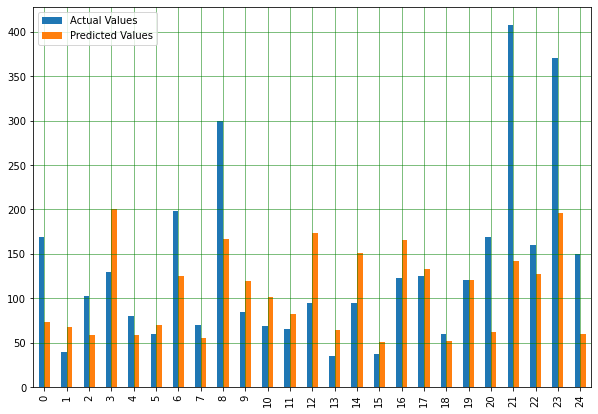

In [36]:
#Prepairng a Decision Tree Regression

DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(X_train,y_train)
y_pred=DTree.predict(X_test)

from sklearn.metrics import r2_score
print("R2 score: ",r2_score(y_test,y_pred)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

#Error
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_pred.flatten()})
print(error_diff.head(5))

#Visualize the error
df1 = error_diff.head(25)
df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

R2 score:  20.413089707399244
RMSE:  101.80843464130007
   Actual Values  Predicted Values
0            169        126.973680
1             40         67.004104
2            102         60.697962
3            130        200.196295
4             80         64.815163


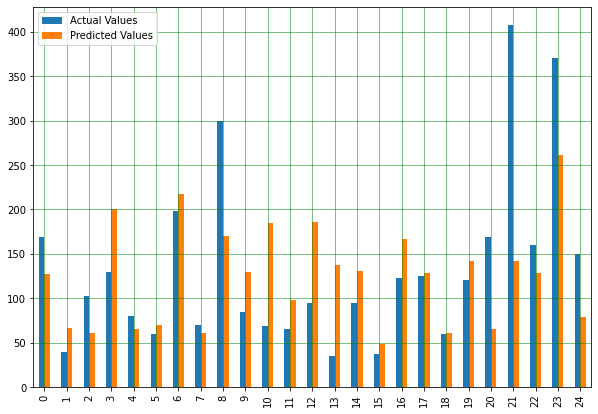

In [39]:
#Random forest regression 
regrRM2 = RandomForestRegressor(n_estimators=200, max_depth = 50, min_samples_split = 5,min_samples_leaf =4)
regrRM2.fit(X_train, y_train)

y_pred=regrRM2.predict(X_test)

from sklearn.metrics import r2_score
print("R2 score: ",r2_score(y_test,y_pred)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

#Error
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_pred.flatten()})
print(error_diff.head(5))

#Visualize the error
df1 = error_diff.head(25)
df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

R2 score:  31.906013810563362
RMSE:  94.17102915813254
   Actual Values  Predicted Values
0            169        131.075977
1             40         65.280811
2            102         69.646973
3            130        199.711908
4             80         66.556275


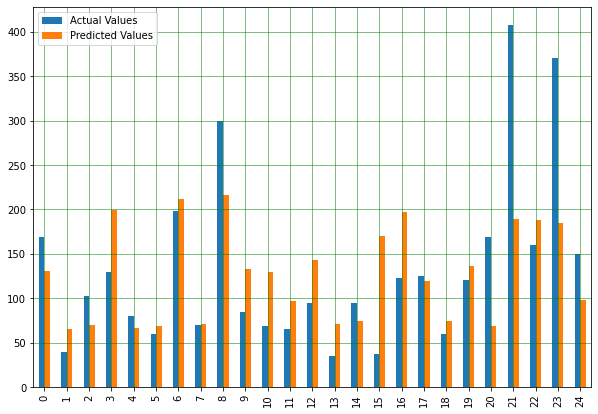

In [40]:
#Gradient Boosting Regressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01)
GBoost.fit(X_train,y_train)

y_pred=GBoost.predict(X_test)

from sklearn.metrics import r2_score
print("R2 score: ",r2_score(y_test,y_pred)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))

#Error
error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_pred.flatten()})
print(error_diff.head(5))

#Visualize the error
df1 = error_diff.head(25)
df1.plot(kind='bar',figsize=(10,7))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()